### LOAD MODEL DARI MODEL HASIL CNN YANG SUDAH ADA SEBELUMNYA DAN AMBIL FEATURE EXTRACTIONNYA

In [2]:
from tensorflow.keras.saving import load_model
import tensorflow as tf

# Load model DenseNet yang sudah dilatih dalam format .keras
model_densenet = load_model('pepaya_disease_model.keras')

# Hilangkan layer klasifikasi (softmax)
feature_extractor = tf.keras.Model(inputs=model_densenet.input, 
                                   outputs=model_densenet.layers[-2].output)  # Layer sebelum softmax

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing data
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    'newdataset/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Agar urutan sesuai untuk SVM
)

valid_gen = datagen.flow_from_directory(
    'newdataset/valid',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    'newdataset/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 401 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
import numpy as np

# Ekstraksi fitur dari training dan testing
train_features = feature_extractor.predict(train_gen, verbose=1)
test_features = feature_extractor.predict(test_gen, verbose=1)

# Simpan label target
train_labels = train_gen.classes
test_labels = test_gen.classes

print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Train Features Shape: (401, 512)
Test Features Shape: (50, 512)


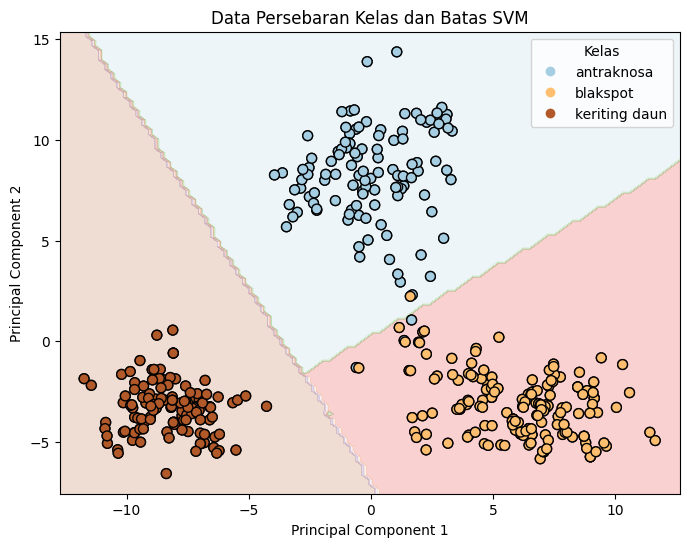

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import datasets

# Misalnya, kita ambil data yang sudah ada (gunakan data train_features dan train_labels Anda)
# Reduksi dimensi dengan PCA menjadi 2D
pca = PCA(n_components=2)
train_features_2d = pca.fit_transform(train_features)

# Melatih SVM dengan kernel linear
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features_2d, train_labels)

# Plot data dengan label kelas
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap=plt.cm.Paired, edgecolors='k', s=50)

# Menambahkan label kelas
plt.title("Data Persebaran Kelas dan Batas SVM")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot batas keputusan SVM
x_min, x_max = train_features_2d[:, 0].min() - 1, train_features_2d[:, 0].max() + 1
y_min, y_max = train_features_2d[:, 1].min() - 1, train_features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)
plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap=plt.cm.Paired, edgecolors='k', s=50)

# Use the scatter variable for legend elements
plt.legend(handles=scatter.legend_elements()[0], title="Kelas", labels=['antraknosa', 'blakspot', 'keriting daun'])

plt.show()


### SAVE MODEL

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler

# Contoh: melatih model SVM dengan scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_gen)  # Menggunakan scaler untuk melatih data

svm_classifier.fit(X_train_scaled, y_train)

# Simpan model dan scaler
joblib.dump(svm_classifier, 'svm_model.pkl')

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi dan latih SVM
svm_classifier = SVC(kernel='linear')  # Coba kernel 'rbf' jika diperlukan
svm_classifier.fit(train_features, train_labels)

# Prediksi pada data testing
test_preds = svm_classifier.predict(test_features)

# Evaluasi performa
print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("Classification Report:\n", classification_report(test_labels, test_preds))

Test Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.94      0.94      0.94        16
           2       0.94      1.00      0.97        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



### Confusion matrix

Accuracy: 0.9600
Precision: 0.9596
Recall: 0.9606
F1 Score: 0.9595


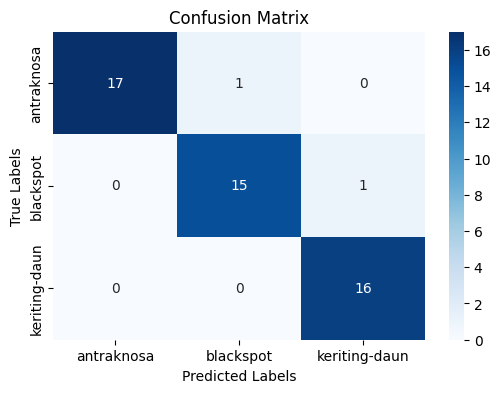

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Hitung metrik evaluasi
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro')  # Gunakan 'macro' atau 'weighted' untuk multi-class
recall = recall_score(test_labels, test_preds, average='macro')
f1 = f1_score(test_labels, test_preds, average='macro')

# Tampilkan metrik evaluasi
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Tampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices, yticklabels=train_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [107]:
from sklearn.metrics import accuracy_score, classification_report, hinge_loss

# Inisialisasi dan latih SVM
svm_classifier = SVC(kernel='linear', probability=True)  # Gunakan 'probability=True' jika perlu probabilitas
svm_classifier.fit(train_features, train_labels)

# Prediksi pada data testing
test_preds = svm_classifier.predict(test_features)

# Evaluasi performa
accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(test_labels, test_preds))

# Hinge Loss
test_loss = hinge_loss(test_labels, svm_classifier.decision_function(test_features))
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.94      0.94      0.94        16
           2       0.94      1.00      0.97        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

Test Loss: 0.0863


## Menampilkan beberapa vektor fitur dari data latih

In [83]:
print("Contoh Vektor Fitur Pertama (Train):")
print(train_features[0])  # Menampilkan vektor fitur pertama

print("\nContoh Vektor Fitur Kedua (Train):")
print(train_features[1])  # Menampilkan vektor fitur kedua

# Jika Anda ingin menampilkan lebih banyak vektor fitur
print("\nContoh Vektor Fitur Ke-5 (Train):")
print(train_features[4])  # Menampilkan vektor fitur kelima

# Dimensi dari fitur yang diekstraksi
print("\nDimensi Fitur yang Diekstraksi:")
print(train_features.shape)


Contoh Vektor Fitur Pertama (Train):
[1.834751   0.5012103  0.08582139 0.         0.         0.
 0.5680718  0.         2.475743   0.         0.         0.
 1.4857187  1.828335   0.         0.48311204 0.48264617 0.
 1.8202603  0.         0.         0.5621357  0.         3.0211658
 0.         1.8695667  0.02484212 0.962024   2.0936873  0.21459864
 0.         1.2009047  0.         0.         2.9550743  1.3232611
 2.613981   0.         0.         0.95101684 0.50826484 1.1173522
 0.         2.7432168  0.         0.         0.         0.
 0.         0.         2.3234215  0.         0.         1.2235534
 0.74378943 2.5847986  1.1389152  0.         0.         0.
 0.         1.0309176  0.         0.         0.         1.2642652
 1.055835   0.         0.         0.18791765 0.         0.44562244
 0.83841246 2.7103076  0.13408844 0.         0.08510957 0.
 0.         0.21446574 0.         0.         1.9530592  0.94819224
 1.4128137  0.         0.5936216  0.         0.         1.0439947
 0.         

In [42]:
# Simpan semua gambar dan label dari test_gen ke dalam array
test_images = []
test_image_labels = []

# Iterasi semua batch dalam test_gen
for batch_images, batch_labels in test_gen:
    test_images.append(batch_images)  # Simpan batch gambar
    test_image_labels.append(batch_labels)  # Simpan batch label
    
    # Break loop ketika semua data sudah diambil
    if len(test_images) * batch_size >= len(test_labels):
        break

# Gabungkan batch menjadi satu array
test_images = np.vstack(test_images)  # Menggabungkan gambar
test_image_labels = np.argmax(np.vstack(test_image_labels), axis=1)  # Mengambil label sebenarnya


## IMAGE TEST YANG DIPREDIKSI SALAH

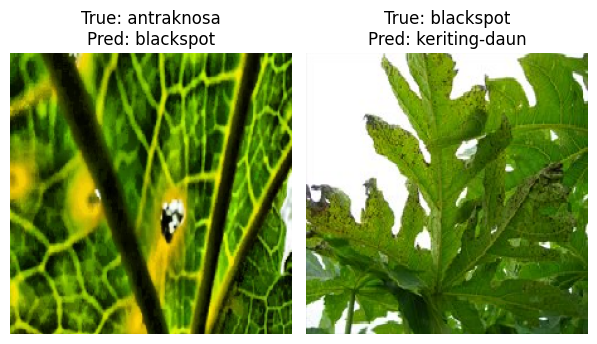

In [44]:
# Identifikasi indeks gambar yang salah klasifikasi
incorrect_indices = np.where(test_preds != test_labels)[0]

# Ambil 4 gambar pertama yang salah prediksi
num_images = min(4, len(incorrect_indices))  # Pastikan maksimal 4 gambar
incorrect_images = [test_images[i] for i in incorrect_indices[:num_images]]  # Ambil gambar
true_labels = [test_labels[i] for i in incorrect_indices[:num_images]]
pred_labels = [test_preds[i] for i in incorrect_indices[:num_images]]

# Mapping class indices ke nama kelas
class_names = list(train_gen.class_indices.keys())

# Tampilkan gambar yang salah klasifikasi
plt.figure(figsize=(12, 8))
for i in range(num_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(incorrect_images[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
